# Mean reverting startegy based on Bollinger bands Strategy

This notebook answers question 3.5 form the text book Advances in Financial Machine Learning.

3.5 Develop a mean-reverting strategy based on Bollinger bands. For each observation, the model suggests a side, but not a size of the bet.

* (a) Derive meta-labels for ptSl = [0, 2] and t1 where numDays = 1. Use as trgt the daily standard deviation as computed by Snippet 3.1.
* (b) Train a random forest to decide whether to trade or not. Use as features: volatility, seial correlation, and teh crossinmg moving averages.
* (c) What is teh accuracy of prediction from the primary model? (i.e. if the secondary model does not filter the bets) What are the precision, recall and FI-scores?
* (d) What is teh accuracy of prediction from the primary model? What are the precision, recall and FI-scores?


In [1]:
import numpy as np
import pandas as pd
import pyfolio as pf
import timeit

from statsmodels.tsa.stattools import adfuller

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, accuracy_score

from mlfinlab.corefns.core_functions import CoreFunctions
from mlfinlab.corefns.financial_functions import FinancialFunctions
from mlfinlab.fracdiff.fracdiff import frac_diff_ffd

import matplotlib.pyplot as plt
%matplotlib inline

### Read in Data
We are using the dollar bars based off of the high quality HFT data we purchased. There is a sample of bars available in this branch as well. 

In [2]:
# Read in data
data = pd.read_csv('official_data/dollar_bars.csv')
data.index = pd.to_datetime(data['date_time'])
data = data.drop('date_time', axis=1)

In [3]:
data = data['2011-09-01':'2018-01-01']

---
### Define helper functions

In [4]:
def relative_strength_index(df, n):
    i = 0
    UpI = [0]
    DoI = [0]
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
        DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)

    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())

    # PosDI = pd.Series(UpI.rolling(window=n).mean())
    # NegDI = pd.Series(DoI.rolling(window=n).mean())

    RSI = pd.Series(round(PosDI * 100. / (PosDI + NegDI)), name='RSI_' + str(n))
    # df = df.join(RSI)
    return RSI

    
# Compute RSI
def get_rsi(data, window=14):
    df = data.copy(deep=True).reset_index()
    rsi = FinancialFunctions.relative_strength_index(df, window)
    rsi_df = pd.Series(data=rsi.values, index=data.index)
    return rsi_df

In [5]:
def compute_side(data):
    # Apply Bolinger band strategy
    """
    The following is a mean reverting strategy using Bollinger Bands:
    * If price above upper band then short.
    * If price below bottom band then long.
    * If price cross mean price then close all positions.
    """
    current_side = 0

    store = []
    for row in data.itertuples():
            # Buy signal
            if row.close > row.upper and current_side != -1:
                current_side = -1
                store.append(current_side)

            # Short signal
            elif row.close < row.lower and current_side != 1:
                current_side = 1
                store.append(current_side)

            # Close signal long
            elif current_side == 1 and row.close > row.avg:
                current_side = 0
                store.append(current_side)

            # Close signal short
            elif current_side == -1 and row.close < row.avg:
                current_side = 0
                store.append(current_side)

            # No action
            else:
                store.append(current_side)
    return store

---
### Fit a Primary Model: Mean-reverting based on Bollinger bands
Based on the mean-reverting Bollinger band strategy.


In [6]:
# compute bands
window = 50
data['avg'], data['upper'], data['lower'] = FinancialFunctions.bbands(data['close'], window, no_of_stdev=2)
data.sample(10)

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,avg,upper,lower
date_time,,,,,,,,,,
2015-07-07 19:59:59.050,2072.75,2074.00,2072.25,2073.75,34014,70525408.50,1986,2054.345,2079.060295,2029.629705
2012-06-29 07:00:00.265,1337.00,1343.00,1336.75,1342.25,52299,70078248.00,12516,1317.520,1332.197082,1302.842918
2011-11-24 13:37:42.201,1171.50,1172.25,1166.25,1167.25,59873,70000180.75,19316,1170.325,1185.993847,1154.656153
2012-09-04 13:40:35.883,1404.75,1405.25,1402.25,1402.50,49873,70007594.50,13887,1404.925,1411.071386,1398.778614
2017-02-22 17:02:41.607,2359.00,2360.00,2358.25,2358.50,29674,70005934.75,2426,2359.960,2364.311120,2355.608880
2015-03-23 20:01:39.849,2096.50,2096.50,2095.25,2095.25,33424,70056993.25,3411,2101.960,2107.757044,2096.162956
2016-12-09 20:08:06.391,2249.00,2251.50,2248.75,2251.50,31128,70035283.25,2436,2246.320,2250.705784,2241.934216
2017-08-21 17:33:52.571,2427.00,2427.50,2425.50,2426.25,28997,70357444.75,2796,2424.795,2431.580857,2418.009143
2011-11-01 13:44:54.508,1217.75,1219.75,1216.00,1216.25,57482,70011870.00,16004,1246.945,1285.591262,1208.298738


In [7]:
# Compute frac diff
fracs = frac_diff_ffd(data['close'].apply(np.log), differencing_amt=0.55, threshold=1e-5)

result = adfuller(fracs, maxlag=2, regression='C', autolag='AIC', store=False, regresults=False)
print('ADF Statistic: %f' % abs(round(result[0], 3)))
print('p-value: %f' % result[1])
print('Critical values:')
for k, v in result[4].items():
    print('\t%s: %.3f' % (k, v))

ADF Statistic: 12.348000
p-value: 0.000000
Critical values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


In [8]:
frac_df = pd.Series(data=fracs, index=data.index)
frac_df.tail()
data['fracdiff'] = [frac_df[x] for x in data.index]

In [9]:
# Compute RSI
rsi_df = get_rsi(data, window=14)
data['rsi'] = pd.Series(data=rsi_df.values, index=data.index)

# Drop the NaN values from our data set
data.dropna(axis=0, how='any', inplace=True)

In [10]:
# data['side'] = compute_side(data)
long_signals = (data['close'] <= data['lower']) & (data['rsi'] <= 25)
short_signals = (data['close'] >= data['upper']) & (data['rsi'] >= 75) 
data.loc[long_signals, 'side'] = 1
data.loc[short_signals, 'side'] = -1

# Remove Look ahead biase by lagging the signal
data['side'] = data['side'].shift(1)


In [11]:
# Save the raw data
raw_data = data.copy()

# Drop the NaN values from our data set
data.dropna(axis=0, how='any', inplace=True)

In [12]:
# print(data.sample(5))
print(data.side.value_counts())

-1.0    2988
 1.0    2863
Name: side, dtype: int64


### Filter Events: CUSUM Filter
Predict what will happen when a CUSUM event is triggered. Use the signal from the MAvg Strategy to determine the side of the bet.

In [13]:
# Compute daily volatility
daily_vol = CoreFunctions.get_daily_vol(close=data['close'], lookback=50)

# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = CoreFunctions.get_t_events(data['close'], threshold=daily_vol.mean() * 0.1)

# Compute vertical barrier
vertical_barriers = CoreFunctions.add_vertical_barrier(t_events=cusum_events, close=data['close'], num_days=1)

Calculating daily volatility for dynamic thresholds
Applying Symmetric CUSUM filter.


100%|███████████████████████████████████████████████████████████████████████████| 5849/5849 [00:00<00:00, 15984.87it/s]


In [14]:
pt_sl = [0, 2]
triple_barrier_events = CoreFunctions.get_events(close=data['close'],
                                  t_events=cusum_events,
                                  pt_sl=pt_sl,
                                  target=daily_vol,
                                  min_ret=0.01,
                                  num_threads=2,
                                  vertical_barrier_times=vertical_barriers,
                                  side=data['side'])

2019-03-07 17:18:11.356052 100.0% apply_pt_sl_on_t1 done after 0.05 minutes. Remaining 0.0 minutes.


In [15]:
labels = CoreFunctions.get_bins(triple_barrier_events, data['close'])

---
### Results of Primary Model:
What is the accuracy of predictions from the primary model (i.e., if the sec- ondary model does not filter the bets)? What are the precision, recall, and F1-scores?

In [16]:
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

C:\Users\singash2\AppData\Local\Continuum\anaconda3\envs\cap\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       293
           1       0.17      1.00      0.30        62

   micro avg       0.17      0.17      0.17       355
   macro avg       0.09      0.50      0.15       355
weighted avg       0.03      0.17      0.05       355

Confusion Matrix
[[  0 293]
 [  0  62]]

Accuracy
0.17464788732394365


---
## Fit a Meta Model
Train a random forest to decide whether to trade or not (i.e 1 or 0 respectively) since the earlier model has decided the side (-1 or 1)

Create the following features: 
* Volatility
* Serial Correlation
* The returns at the different lags from the serial correlation
* The sides from the SMavg Strategy

In [17]:
raw_data.head()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,avg,upper,lower,fracdiff,rsi,side
date_time,,,,,,,,,,,,,
2011-09-02 12:08:00.131,1191.75,1193.75,1189.75,1192.00,58751,70015084.25,19832,1212.455,1229.830414,1195.079586,0.0,22.0,NaN
2011-09-02 12:30:35.193,1192.00,1198.50,1182.00,1183.25,58894,70005676.00,18835,1211.720,1230.816597,1192.623403,0.0,11.0,1.0
2011-09-02 12:34:43.063,1183.50,1185.50,1179.75,1180.25,59197,70003214.75,17995,1211.010,1232.037184,1189.982816,0.0,10.0,1.0
2011-09-02 12:46:13.588,1180.25,1185.25,1179.75,1182.50,59181,70015589.25,20245,1210.460,1232.980594,1187.939406,0.0,11.0,1.0
2011-09-02 13:16:37.863,1182.50,1184.00,1180.25,1180.50,59208,70001715.00,21976,1209.820,1233.870763,1185.769237,0.0,4.0,1.0


### Features

In [18]:
# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

# Volatility
window_stdev = 50
raw_data['volatility'] = raw_data['log_ret'].rolling(window=window_stdev, min_periods=window_stdev, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

# Add fast and slow moving averages
fast_window = 7
slow_window = 15

raw_data['fast_mavg'] = raw_data['close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
raw_data['slow_mavg'] = raw_data['close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()


In [19]:
# Re compute sides
raw_data['side'] = np.nan

long_signals = (raw_data['close'] <= raw_data['lower']) & (raw_data['rsi'] <= 25)
short_signals = (raw_data['close'] >= raw_data['upper']) & (raw_data['rsi'] >= 75) 

raw_data.loc[long_signals, 'side'] = 1
raw_data.loc[short_signals, 'side'] = -1

In [20]:
# Remove look ahead bias
raw_data = raw_data.shift(1)

#### Now get the data at the specified events

In [21]:
# Get features at event dates
X = raw_data.loc[labels.index, :]

# Drop unwanted columns
X.drop(['open', 'high', 'low', 'close', 'cum_vol', 'cum_dollar', 'cum_ticks','fast_mavg', 'slow_mavg',], axis=1, inplace=True)

y = labels['bin']
X.head()

,avg,upper,lower,fracdiff,rsi,side,log_ret,mom1,mom2,mom3,...,autocorr_1,autocorr_2,autocorr_3,autocorr_4,autocorr_5,log_t1,log_t2,log_t3,log_t4,log_t5
2011-09-07 08:36:06.996,1151.935,1170.056700,1133.813300,0.0,75.0,-1.0,-0.002341,-0.002338,0.004064,0.008162,...,-0.110341,0.211740,0.029460,-0.038646,-0.271445,0.006397,0.004072,-0.000859,-0.000429,0.001932
2011-09-09 13:29:55.599,1191.800,1205.176037,1178.423963,0.0,11.0,1.0,-0.001066,-0.001066,-0.004673,-0.006151,...,0.106034,-0.207744,0.152389,0.021149,0.089492,-0.003617,-0.001486,-0.004022,-0.001478,-0.001475
2011-09-12 11:58:36.577,1154.915,1180.516062,1129.313938,0.0,24.0,1.0,-0.005082,-0.005069,-0.002872,-0.009001,...,-0.218796,0.397666,-0.179821,0.157733,-0.023816,0.002207,-0.006166,-0.001097,-0.008299,0.002177
2011-09-12 19:55:17.718,1139.535,1151.281910,1127.788090,0.0,80.0,-1.0,0.004565,0.004575,0.004794,0.009413,...,-0.069436,0.323715,-0.128058,0.180148,-0.154351,0.000218,0.004587,-0.000657,0.002190,0.003074
2011-09-13 14:08:27.726,1145.850,1164.555832,1127.144168,0.0,86.0,-1.0,0.001074,0.001074,0.003014,0.004095,...,0.151301,-0.243261,-0.131077,0.021893,0.148931,0.001936,0.001077,0.004536,0.002601,-0.003683


### Fit a model

In [31]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [23]:
# Random Forest Model
n_estimator = 50
c_random_state = 42
depth = 9

rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state)
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

#### Training Metrics

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       236
           1       1.00      1.00      1.00        48

   micro avg       1.00      1.00      1.00       284
   macro avg       1.00      1.00      1.00       284
weighted avg       1.00      1.00      1.00       284

Confusion Matrix
[[236   0]
 [  0  48]]

Accuracy
0.17464788732394365


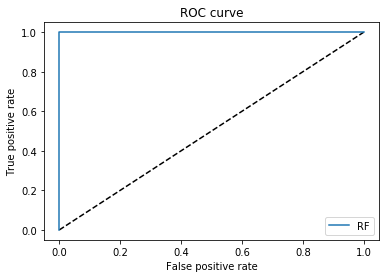

In [24]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

This is overfitting big time 

#### Test Metrics

              precision    recall  f1-score   support

           0       0.82      0.96      0.89        57
           1       0.50      0.14      0.22        14

   micro avg       0.80      0.80      0.80        71
   macro avg       0.66      0.55      0.55        71
weighted avg       0.76      0.80      0.76        71

Confusion Matrix
[[55  2]
 [12  2]]

Accuracy
0.17464788732394365


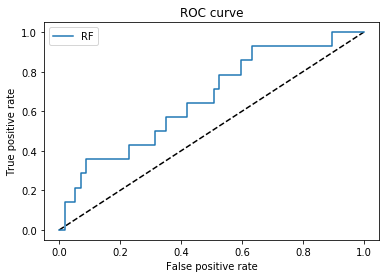

In [25]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

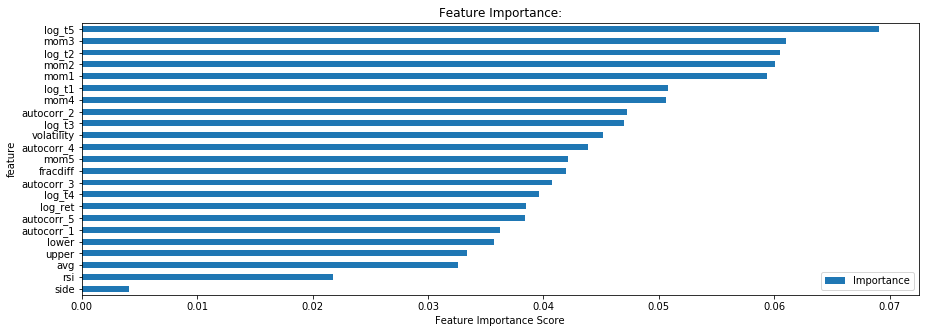

In [26]:
# Feature Importance
title = 'Feature Importance:'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()

Note how low the side is ranked. If we look at the performance of the primary model we will see that the M-R strategy gets only 21% of the trades correct.

---
### Use PCA to shrink the predictor space

In [27]:
# standardize the data
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

scaler = StandardScaler()

# fit the training set only
scaler.fit(X_train)

# Apply the transform to both training and test sets
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

# make an instance of the PCA model with 95% coverage
pca = PCA(0.90)

# fit teh PCA model
pca.fit(X_train_std)
print(pca.n_components_)

# transform both training and test sets
X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

11


### Training Metrics (PCA)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       236
           1       1.00      0.94      0.97        48

   micro avg       0.99      0.99      0.99       284
   macro avg       0.99      0.97      0.98       284
weighted avg       0.99      0.99      0.99       284

Confusion Matrix
[[236   0]
 [  3  45]]

Accuracy
0.17464788732394365


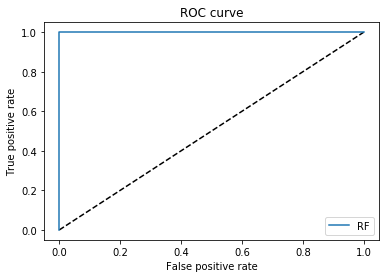

In [29]:
# Apply RF 
rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state)
rf.fit(X_train_pca, y_train.values.ravel())

# Performance Metrics
y_pred_rf = rf.predict_proba(X_train_pca)[:, 1]
y_pred = rf.predict(X_train_pca)

fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Test Metrics (PCA)

C:\Users\singash2\AppData\Local\Continuum\anaconda3\envs\cap\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.80      1.00      0.89        57
           1       0.00      0.00      0.00        14

   micro avg       0.80      0.80      0.80        71
   macro avg       0.40      0.50      0.45        71
weighted avg       0.64      0.80      0.72        71

Confusion Matrix
[[57  0]
 [14  0]]

Accuracy
0.17464788732394365


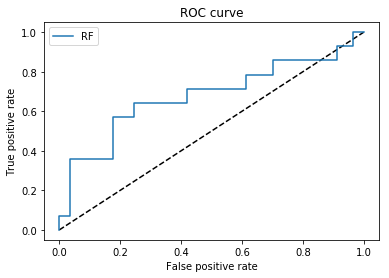

In [30]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_test_pca)[:, 1]
y_pred = rf.predict(X_test_pca)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

---
## Performance Tear Sheets

In [138]:
test_dates = X_test.index

print(pf.show_perf_stats(labels.loc[test_dates, 'ret']))
print(pf.show_worst_drawdown_periods(labels.loc[test_dates, 'ret']))

Start date,2015-03-18
End date,2011-11-17
Total months,3
,Backtest
Annual return,-0.7%
Cumulative returns,-0.2%
Annual volatility,24.4%
Sharpe ratio,0.09
Calmar ratio,-0.08
Stability,0.19
Max drawdown,-8.3%


None


C:\Users\singash2\AppData\Local\Continuum\anaconda3\envs\cap\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.28,2015-05-08,2012-08-14,2011-10-20,0
1,6.97,2013-03-25,2015-08-31,NaT,NaN
2,0.00,2015-03-18,2015-03-18,2015-03-18,1
3,0.00,2015-03-18,2015-03-18,2015-03-18,1
4,0.00,2015-03-18,2015-03-18,2015-03-18,1


None


In [139]:
meta_returns = labels.loc[test_dates, 'ret'] * y_pred

print(pf.show_perf_stats(meta_returns))
print(pf.show_worst_drawdown_periods(meta_returns))

C:\Users\singash2\AppData\Local\Continuum\anaconda3\envs\cap\lib\site-packages\empyrical\stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
C:\Users\singash2\AppData\Local\Continuum\anaconda3\envs\cap\lib\site-packages\empyrical\stats.py:790: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
C:\Users\singash2\AppData\Local\Continuum\anaconda3\envs\cap\lib\site-packages\empyrical\stats.py:1511: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Start date,2015-03-18
End date,2011-11-17
Total months,3
,Backtest
Annual return,0.0%
Cumulative returns,0.0%
Annual volatility,0.0%
Sharpe ratio,NaN
Calmar ratio,NaN
Stability,0.00
Max drawdown,0.0%


None


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.00,2015-03-18,2015-03-18,2015-03-18,1
1,0.00,2015-03-18,2015-03-18,2015-03-18,1
2,0.00,2015-03-18,2015-03-18,2015-03-18,1
3,0.00,2015-03-18,2015-03-18,2015-03-18,1
4,0.00,2015-03-18,2015-03-18,2015-03-18,1


None


---
## Conclusion
